# Autonomous Vehicle Model Training

This notebook trains the model that is running in our production vehicle. We will walk through first loading the data, cleaning/preprocessing and then finally making predictions. We are using a relatively light CNN as the final model. 

## Imports

In [ ]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib.pyplot import Rectangle
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from utils import sorted_nicely
from utils import absSobelThresh
from utils import combinedThreshBinaryImg
from utils import load_data

## Loading The Data & Preprocessing

Here, we load the data and then use kernels and thresholding to preprocess the images. This makes it easier for the model to detect edges and thus follow lanes.

In [6]:
speeds = pd.read_csv('train_wheel_speeds.csv')
images = load_data('training_images')[:-1]

In [7]:
#Delete bad training data(setting up things the speeds are 0 - we remove these)
mask = np.array((speeds['0'] == 0) & (speeds['1'] == 0))
images = np.array(images)
images = images[~mask]
speeds = speeds[~mask]

In [8]:
#Since it takes time to capture images, we shift the speeds by 1 to match up to the images
y = np.array(speeds)
y = np.delete(y,0, axis=1)
y = y[1:]
images = images[:-1]
X = images.reshape(images.shape[0],68,128,1)

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=12)

## Model

Final model for the task, we are using 6 convolution layers and finally end with 2 fully connected layers. Surprsingly a simple cnn worked very well for our needs. This is also fast to train locally or on a GPU enabeled cloud/local computer.

In [27]:
img = Input(shape = (68, 128, 1), name = 'images')
x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
        
diff = tf.keras.layers.Dense(1, name = "left")(x)
turn = tf.keras.layers.Dense(1, name = "right")(x)
model = Model(img, [diff, turn])

model.compile("adam", loss = {'left': 'mse', 'right': 'mse'})


In [ ]:
history = model.fit(X_train, y_train, val_split = 0.2, batch_size =32, epochs = 150 )

## Model Evaluation

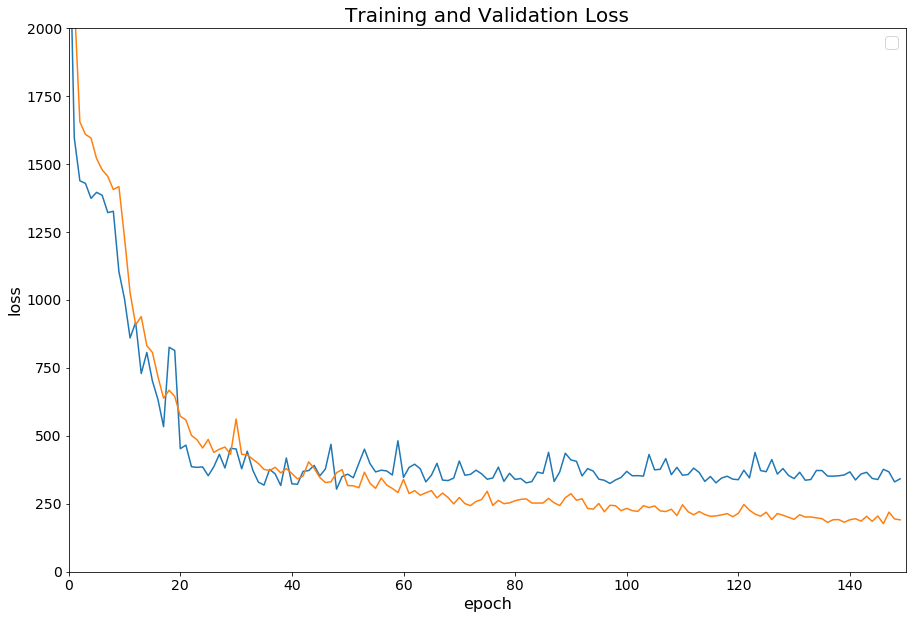

In [30]:
plt.figure(figsize=(12,7))
plt.ylim(0,2500)
plt.xlim(0,150)
plt.title('Training and Validation Loss', fontsize=20)
plt.legend(labels=['validation','training'],fontsize=16)
plt.xlabel('epoch', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [34]:
#Make Predictions
preds = model.predict(X_test)

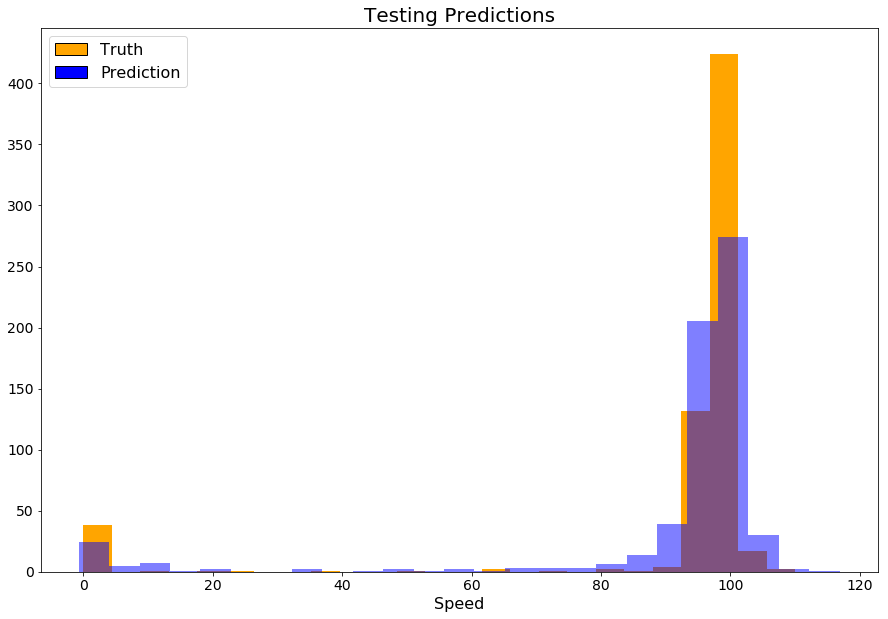

In [35]:
#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['orange','blue']]
labels= ["Truth","Prediction"]
plt.figure(figsize=(12,7))
plt.title('Testing Predictions', fontsize=20)
plt.legend(handles= handles, labels=labels,fontsize=16, loc='upper left')
plt.xlabel('Speed', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.hist(y_test[:,0], bins=25, label="Truth", color='orange')
plt.hist(preds[1], alpha=.5, bins=25, label="Prediction", color='blue')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15,10))
n = 4
m = 4

for i,s in enumerate(images[1010:1120]):
    try:
        fig.add_subplot(n,m,i+1)
        plt.imshow(s)
        title = str(preds[i]) + " | " + str(y_test[i])
#         title = y_test[60+i]
        plt.title(title)
    except:
        pass
plt.show()

In [29]:
#Save Model to disk
model_json = model.to_json()
with open("final_trained_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("final_trained_model.h5")
print("Saved model to disk\n")

Saved model to disk

